In [2]:
!pip install git+https://github.com/millawell/bias-ml-dh.git#subdirectory=material/notebooks/bias_ml_dh_utils
!pip install --upgrade tqdm

  Cloning https://github.com/millawell/bias-ml-dh.git to /private/var/folders/jp/c1yk1wvn6x58ftj04zg1z8680000gn/T/pip-req-build-3zdgzc63
  Running command git clone -q https://github.com/millawell/bias-ml-dh.git /private/var/folders/jp/c1yk1wvn6x58ftj04zg1z8680000gn/T/pip-req-build-3zdgzc63
^C
Requirement already up-to-date: tqdm in /Users/davidlassner/Envs/wh4/lib/python3.7/site-packages (4.43.0)


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import spacy
import numpy as np
import torch as tr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from collections import Counter
from spacy.tokenizer import Tokenizer

from bisect import bisect_left
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import bias_ml_dh_utils as utils

nlp = spacy.load("en_core_web_sm")

In [10]:
data_identifier = "yelp_sentiment_english"
password = b"dWaOtRaKsSeHtOsP"
embedding_identifier = "glove.6B.50d"

In [12]:
def load_data(data='yelp_sentiment_english'):
    #loads data and feeds it into a data frame
    
    if data in("yelp_sentiment_englosh","amazon_sentiment_engl","imdb"):
        
        path_to_data = utils.download_dataset(data, password)

        df = pd.read_csv(path_to_data, names=['sentence', 'label'], sep='\t')

        sentences = df['sentence'].values
        y = df['label'].values

        df['spacified'] = list(nlp.pipe(df['sentence']))
        df['lemmatized'] = df.spacified.apply(lambda doc: [t.lemma_ for t in doc])
        cnts = Counter(l for doc in df.lemmatized for l in doc)
        vocab = sorted([el[0] for el in cnts.items() if el[1] >= 10])
        vocab.insert(0," ")

        max_it = 40
        
    elif data=="wikipedia":
        
        path_to_data  = utils.download_dataset(data, password)
        aggression_data = pd.read_pickle(path_to_data)

        sentences = []
        labels = []
        for rev_id, rev in tqdm(agression_data.groupby("rev_id")):
            sentences.append(rev.iloc[0].comment)
            labels.append(rev.aggression.sum()/len(rev) >.5)

        with open("data/vocab.txt") as fin:
            vocab,_ = zip(*map(lambda x: x.split(" "), fin))
            vocab = sorted(list(vocab) + ["<unk>"])  

        max_it = 100
        y = np.array(labels)
        
    else:
        raise ValueError('data not known')
        
    return vocab, sentences, y, max_it

In [6]:
def set_embedding_path(pretrained_embeddings='glove'):
    #sets path to load embeddings later
    
    if pretrained_embeddings=='glove':

        embedding_dim = 50
        embedding_path = utils.download_dataset("glove.6B.50d", password)

    elif pretrained_embeddings=='all':
        
        embedding_dim = 32
        embedding_path = "data/all_comments_vec.txt"
        
    elif pretrained_embeddings=='aggressive':
        
        embedding_dim = 32
        embedding_path = "data/aggressive_comments_vec.txt"
        
    elif pretrained_embeddings=='non-aggressive':
        
        embedding_dim = 32
        embedding_path = "data/non_aggressive_comments_vec.txt"
        
    return embedding_dim, embedding_path

In [5]:
def prepare_data(data):
    #loads data, extracts relevant data, pads data, train/validation/test split

    vocab, sentences, y, max_it = load_data(data)
    word_seq = utils.tokenize_data(sentences, vocab)
    y = y[:word_seq.shape[0]]

    max_row = utils.get_max_row(word_seq)

    input_data = utils.data_padding(word_seq, np.min([max_row, 500]))
    
    x_train,x_test,y_train,y_test = train_test_split(
                                                    input_data.numpy(), y,  
                                                    test_size=0.2)

    x_val,x_test,y_val,y_test = train_test_split(
                                                    x_test, y_test,  
                                                    test_size=0.5)
    
    return x_train, x_val, x_test, y_train, y_val, y_test, vocab, max_it

In [7]:
def train_classifier(net, x_train, y_train, x_val, y_val, max_it=100):
    
    #sets optimizer and loss function
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    criterion = nn.BCEWithLogitsLoss()


    loss_hist = []
    loss_val_hist = []

    for it in range(max_it):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(tr.from_numpy(x_train))
        loss = criterion(outputs, tr.from_numpy(y_train[:,np.newaxis]).float())
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.detach())

        if it%10==0 or it==(max_it-1):
            print("training loss: ", loss_hist[-1])

            outputs_val = net.forward(tr.from_numpy(x_val))
            loss_val_hist.append(criterion(outputs_val, tr.from_numpy(y_val[:,np.newaxis]).float()).detach())

            print("validation loss: ",loss_val_hist[-1])
            
    y_predict = (outputs_val.detach().numpy()>=0).astype(int).ravel()
    print(classification_report(y_val, y_predict))

    plt.plot(loss_hist)
    plt.plot(np.arange(0,max_it+1,10),loss_val_hist)
    plt.legend(['training_loss', 'validation_loss'])
    plt.savefig('loss.png', dpi=300)
    
    outputs_val = net.forward(tr.from_numpy(x_test))
    y_predict = (outputs_val.detach().numpy()>=0).astype(int).ravel()
    print(classification_report(y_test, y_predict))
            
    return loss_hist, loss_val_hist, outputs_val

In [8]:
def predict_label(input_data, label_names = ['negative','positive']):
    #applies trained model to input_data and predicts the corresponding label
    word_seq = utils.tokenize_data(input_data, vocab)
    X = utils.data_padding(word_seq)
    net.eval()
    output = net.forward(X)
    label = tr.clamp(tr.sign(output.detach()),0,1)
    
    print("The predicted label is: ",label_names[int(label)])
    
    return output.detach()

In [13]:
#prepares train and test data
x_train, x_val, x_test, y_train, y_val, y_test, vocab, max_it = prepare_data("yelp_sentiment_english")

embedding_dim, embedding_path = set_embedding_path(pretrained_embeddings)
embedding_matrix = utils.create_embedding_matrix(
    embedding_path,
    vocab,  
    embedding_dim)

ValueError: data not known

In [45]:
 ## OWN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        filter_sizes = [1,2,3,5]
        num_filters = 36
        
        #Embedding layer
        self.embedding_layer = nn.Embedding(embedding_matrix.shape[0], embedding_dim)
        self.embedding_layer.weight = nn.Parameter(tr.from_numpy(embedding_matrix).float())
        self.embedding_layer.weight.requires_grad = False
        
        #Convolution layer
        self.convolution_layer = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in filter_sizes])
        Ks = [nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in filter_sizes]
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(len(Ks)*num_filters, 1)
        
    def forward(self,x):
        x = self.embedding_layer(x)
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convolution_layer] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = tr.cat(x, 1)
        x = self.dropout(x)
        logit = self.linear(x)
        return(logit)
    
net = Net()

training loss:  tensor(0.7051)
validation loss:  tensor(0.6915)
training loss:  tensor(0.5420)
validation loss:  tensor(0.5526)
training loss:  tensor(0.4253)
validation loss:  tensor(0.4916)
training loss:  tensor(0.3156)
validation loss:  tensor(0.4963)
training loss:  tensor(0.2281)
validation loss:  tensor(0.5340)
              precision    recall  f1-score   support

           0       0.76      0.71      0.73        48
           1       0.75      0.79      0.77        52

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        48
           1       0.71      0.77      0.74        52

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



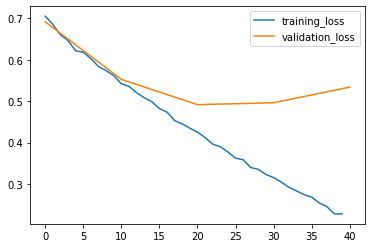

In [46]:
_ = train_classifier(net, x_train, y_train, x_val, y_val, max_it)

In [48]:
#Try out new data!
data = ['this movie was really bad']
_ = predict_label(data)

1it [00:00, 1773.49it/s]

The predicted label is:  negative
